In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [2]:
data = pd.read_csv('data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


### Train and Test sets for models

In [3]:
target_variable = 'converted'

X = data.drop(target_variable, axis=1)
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print('Target variable :', target_variable)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')
Target variable : converted



In [4]:
# Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Preprocessing

In [5]:
numeric_features = ['age', 'total_pages_visited']
categorical_features = ['new_user', 'country', 'source']

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['new_user', 'country', 'source']


In [6]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) 
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:])

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
137434   China   19         1     Seo                    1
112323      US   33         1  Direct                    5
143261      US   51         1     Ads                    2
162328   China   17         0     Seo                    1
158039   China   28         1     Seo                    5
...Done.
[[-1.3990984  -1.15935344  1.          0.          0.          0.
   0.          1.        ]
 [ 0.29299544  0.03743241  1.          0.          0.          1.
   1.          0.        ]
 [ 2.46854467 -0.86015697  1.          0.          0.          1.
   0.          0.        ]
 [-1.64082609 -1.15935344  0.          0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.03743241  1.          0.          0.          0.
   0.          1.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
138303      UK   34         

## Performance assessment 
- f1_score, cross_val_score, confusion matrices, Feature Importance and Classification report

In [8]:
def evaluate_performance(model):
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)

  # Here, the f1-score will be used to assess the performances on the leaderboard
  print(model.__class__.__name__)
  print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
  print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
  print()
  
  scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='f1')
  print('The cross-validated f1 score is : ', scores.mean())
  print('The standard deviation is : ', scores.std())
  print('is this model overfitting ? ', f1_score(Y_test, Y_test_pred) - f1_score(Y_train, Y_train_pred) > scores.std())

  # Visualize confusion matrices
  _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
  axes[0].set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=axes[0]) # ConfusionMatrixDisplay from sklearn

  axes[1].set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=axes[1]) # ConfusionMatrixDisplay from sklearn
  plt.show()

  # Feature Importance
  # numeric_features +  encoded categorical column names
  columns = np.append(numeric_features, preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(categorical_features))
  try:
    coefs = pd.DataFrame(index=columns, data=model.coef_.transpose(), columns=['coefficients'] )
    # Compute abs() and sort values
    feature_importance = abs(coefs).sort_values(by = 'coefficients')
    # Plot coefficients
    fig = px.bar(feature_importance, orientation = 'h', title='Feature Importance')
    fig.update_layout(showlegend = False, 
                      margin = {'l': 120} # to avoid cropping of column names
                      )
    fig.show()
  except:
    pass

  # Classification report
  print('classification_report on Train set')
  print(classification_report(Y_train,Y_train_pred))
  print('---')
  print('classification_report on Test set')
  print(classification_report(Y_test,Y_test_pred))

In [9]:
def get_f1_score(model):
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)

  # Here, the f1-score will be used to assess the performances on the leaderboard
  print(model.__class__.__name__)
  print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
  print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

## Models

#### **Simple Models**

In [10]:
model_1 = DecisionTreeClassifier()
model_2 = RandomForestClassifier()
model_3 = LogisticRegression()
model_4 = AdaBoostClassifier()
model_5 = GradientBoostingClassifier()
model_6 = XGBClassifier()
model_7 = SGDClassifier()
model_8 = KNeighborsClassifier()
model_9 = LGBMClassifier()

In [11]:
# Which base model fitting better with our dataset
for model in [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9]:
  model.fit(X_train, Y_train)
  get_f1_score(model)

DecisionTreeClassifier
f1-score on train set :  0.8026185582705335
f1-score on test set :  0.7174641877476381
RandomForestClassifier
f1-score on train set :  0.8070540962869261
f1-score on test set :  0.7336114421930869
LogisticRegression
f1-score on train set :  0.7654507084715104
f1-score on test set :  0.7554347826086957
AdaBoostClassifier
f1-score on train set :  0.7575872247029442
f1-score on test set :  0.7481146304675715
GradientBoostingClassifier
f1-score on train set :  0.7643552403229458
f1-score on test set :  0.7508265704839194
XGBClassifier
f1-score on train set :  0.7772533153517645
f1-score on test set :  0.7491778774289984
SGDClassifier
f1-score on train set :  0.7638541429762717
f1-score on test set :  0.7493179751439831
KNeighborsClassifier
f1-score on train set :  0.7795484727755646
f1-score on test set :  0.7341398642667454
LGBMClassifier
f1-score on train set :  0.773591943304737
f1-score on test set :  0.7479964381121994


##### Best Models are **Logistic Regression, GradientBoosting, XGBoost and SGDClassifier**

#### **Voting**

##### all models

In [132]:
voting_classifier = VotingClassifier([('Tree', model_1), ('Forest', model_2), ('log_reg', model_3), ('adaboost', model_4), ('gradientboost', model_5), ('xgboost', model_6), ('sgdc', model_7), ('kneighbors', model_8), ('lgbm', model_9)], voting='hard')

voting_classifier.fit(X_train, Y_train)

VotingClassifier(estimators=[('Tree', DecisionTreeClassifier()),
                             ('Forest', RandomForestClassifier()),
                             ('log_reg', LogisticRegression()),
                             ('adaboost', AdaBoostClassifier()),
                             ('gradientboost', GradientBoostingClassifier()),
                             ('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_s...
                                            learning_rate=0.300000012,
                                            max_bin=256, max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves

In [133]:
get_f1_score(voting_classifier)

VotingClassifier
f1-score on train set :  0.7781009920190946
f1-score on test set :  0.7512630014858841


##### best models

In [139]:
voting_classifier_best = VotingClassifier([('log_reg', model_3), ('gradientboost', model_5), ('xgboost', model_6)], voting='hard')

voting_classifier_best.fit(X_train, Y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('gradientboost', GradientBoostingClassifier()),
                             ('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                            

#### **Bagging**

##### DecisionTree (with hyperparameter optimization)

In [15]:
# Decision tree
# Perform grid search
print("Grid search...")
dt = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [8, 10, 12], 
    'min_samples_leaf': [10, 12, 14],
    'min_samples_split': [2, 3, 4]
}
dt_opt = GridSearchCV(dt, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
dt_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", dt_opt.best_params_)
print("Best validation accuracy : ", dt_opt.best_score_)
print()
get_f1_score(dt_opt)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 2}
Best validation accuracy :  0.9856059807435519

GridSearchCV
f1-score on train set :  0.7662841073192976
f1-score on test set :  0.7435351384240949


##### RandomForest (with hyperparameter optimization)

In [26]:
# Perform grid search
print("Grid search...")
random_forest = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10], 
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
print(params)
random_forest_opt = GridSearchCV(random_forest, param_grid = params, cv = 3, verbose = 1) 
# cv : the number of folds to be used for CV
random_forest_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", random_forest_opt.best_params_)
print("Best validation accuracy : ", random_forest_opt.best_score_)
print()
get_f1_score(random_forest_opt)

Grid search...
{'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 4, 8], 'n_estimators': [10, 20, 40, 60, 80, 100]}
Fitting 3 folds for each of 270 candidates, totalling 810 fits
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}
Best validation accuracy :  0.9861638203668565

GridSearchCV
f1-score on train set :  0.767815042969047
f1-score on test set :  0.7428397318708104


##### Kneighbors

In [20]:
bagging_kneighbors = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators = 5)
bagging_kneighbors.fit(X_train, Y_train)
get_f1_score(bagging_kneighbors)

BaggingClassifier
f1-score on train set :  0.7824324324324325
f1-score on test set :  0.732810615199035


#### **Boosting**

##### Adaboost with logistic regression as base estimator

In [50]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
adaboost_log_reg = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5,], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [5, 10, 20, 30] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
adaboost_log_reg_opt = GridSearchCV(adaboost_log_reg, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
adaboost_log_reg_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", adaboost_log_reg_opt.best_params_)
print("Best validation accuracy : ", adaboost_log_reg_opt.best_score_)
print()
get_f1_score(adaboost_log_reg_opt)

Grid search...
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5], 'n_estimators': [5, 10, 20, 30]}
...Done.
Best hyperparameters :  {'base_estimator__C': 0.5, 'n_estimators': 30}
Best validation accuracy :  0.985092065500035

GridSearchCV
f1-score on train set :  0.7356931233432092
f1-score on test set :  0.7215466167758028


##### Adaboost with decision tree as base estimator

In [68]:
adaboost_model = AdaBoostClassifier(n_estimators=100)

In [57]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
adaboost_dt = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [8, 10, 12], # d’abord on va tester avec [ 2, 4, 6, 8, 10, 12, 14, …, 20 ]
    # si le meilleur paramètre est 10, on va zoomer sur les valeurs autour de 10. [ 8, 10, 12 ]
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [6, 8, 10],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
adaboost_dt_opt = GridSearchCV(adaboost_dt, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
adaboost_dt_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", adaboost_dt_opt.best_params_)
print("Best validation accuracy : ", adaboost_dt_opt.best_score_)
print()
get_f1_score(adaboost_dt_opt)

Grid search...
{'base_estimator__max_depth': [6, 8, 10], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [4, 8, 10], 'n_estimators': [4, 6, 8, 10]}
Fitting 3 folds for each of 108 candidates, totalling 324 fits
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 6, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 4, 'n_estimators': 8}
Best validation accuracy :  0.9858827043362147

GridSearchCV
f1-score on train set :  0.7717860866974527
f1-score on test set :  0.7472462042274486


##### GradientBoosting

In [58]:
# Perform grid search
print("Grid search...")
gradientboost = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 8, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12]
}
print(params)
gradientboost_opt = GridSearchCV(gradientboost, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gradientboost_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gradientboost_opt.best_params_)
print("Best validation accuracy : ", gradientboost_opt.best_score_)
print()
get_f1_score(gradientboost_opt)

Grid search...
{'max_depth': [8, 10, 12], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [6, 8, 10], 'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 12}
Best validation accuracy :  0.9853072949609952

GridSearchCV
f1-score on train set :  0.755223643441646
f1-score on test set :  0.732092142631745


##### XGBoost

In [104]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, Y_train)
get_f1_score(xgboost_model)

XGBClassifier
f1-score on train set :  0.7772533153517645
f1-score on test set :  0.7491778774289984


XGBClassifier
f1-score on train set :  0.7772533153517645
f1-score on test set :  0.7491778774289984

The cross-validated f1 score is :  0.7606697430773302
The standard deviation is :  0.008626496295500321
is this model overfitting ?  False


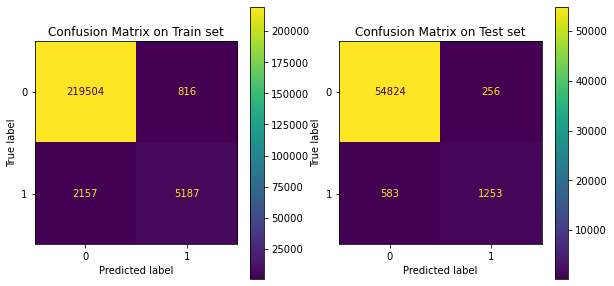

classification_report on Train set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.71      0.78      7344

    accuracy                           0.99    227664
   macro avg       0.93      0.85      0.89    227664
weighted avg       0.99      0.99      0.99    227664

---
classification_report on Test set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.83      0.68      0.75      1836

    accuracy                           0.99     56916
   macro avg       0.91      0.84      0.87     56916
weighted avg       0.98      0.99      0.98     56916



In [105]:
evaluate_performance(xgboost_model)

##### XGBoost (with hyperparameter optimization)

In [48]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [13, 14, 15],
    'min_child_weight': [15, 20, 25],
    'n_estimators': [8, 10, 12]
}
print(params)
xgboost_opt = GridSearchCV(xgboost, param_grid = params, scoring='f1', cv = 3, verbose = 1) # cv : the number of folds to be used for CV
xgboost_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", xgboost_opt.best_params_)
print("Best validation accuracy : ", xgboost_opt.best_score_)
print()
get_f1_score(xgboost_opt)

Grid search...
{'max_depth': [13, 14, 15], 'min_child_weight': [15, 20, 25], 'n_estimators': [8, 10, 12]}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END max_depth=13, min_child_weight=15, n_estimators=8;, score=0.754 total time=   0.5s
[CV 2/3] END max_depth=13, min_child_weight=15, n_estimators=8;, score=0.767 total time=   0.5s
[CV 3/3] END max_depth=13, min_child_weight=15, n_estimators=8;, score=0.765 total time=   0.5s
[CV 1/3] END max_depth=13, min_child_weight=15, n_estimators=10;, score=0.756 total time=   0.5s
[CV 2/3] END max_depth=13, min_child_weight=15, n_estimators=10;, score=0.767 total time=   1.0s
[CV 3/3] END max_depth=13, min_child_weight=15, n_estimators=10;, score=0.766 total time=   0.6s
[CV 1/3] END max_depth=13, min_child_weight=15, n_estimators=12;, score=0.753 total time=   0.8s
[CV 2/3] END max_depth=13, min_child_weight=15, n_estimators=12;, score=0.767 total time=   0.8s
[CV 3/3] END max_depth=13, min_child_weight=15, n_estimators

#### **Stacking**

##### best models

In [ ]:
stacking_classifier_best = StackingClassifier([('log_reg', model_3), ('gradientboost', model_5), ('xgboost', model_6)], final_estimator=KNeighborsClassifier())

stacking_classifier_best.fit(X_train, Y_train)

## Submission

In [22]:
def retrain_and_submit(model, version=1):
  print(model)
  # Concatenate our train and test set to train your best classifier on all data with labels
  X = np.append(X_train,X_test,axis=0)
  Y = np.append(Y_train,Y_test)

  model.fit(X,Y)

  # Read data without labels
  data_without_labels = pd.read_csv('data/conversion_data_test.csv')
  print('Prediction set (without labels) :', data_without_labels.shape)

  # apply the preprocessing
  X_without_labels = preprocessor.transform(data_without_labels)
  data = {
    'converted': model.predict(X_without_labels)
  }

  Y_predictions = pd.DataFrame(columns=['converted'],data=data)
  Y_predictions.to_csv(f'submissions/conversion_data_test_predictions_Alexon_V{version}.csv', index=False)
  print('Done ....')

In [45]:
retrain_and_submit(dt_opt.best_estimator_, version=5)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=12)
Prediction set (without labels) : (31620, 5)
Done ....


In [46]:
retrain_and_submit(random_forest_opt.best_estimator_, version=6)

RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=4)
Prediction set (without labels) : (31620, 5)
Done ....


In [54]:
retrain_and_submit(adaboost_log_reg_opt.best_estimator_, version=7)

AdaBoostClassifier(base_estimator=LogisticRegression(C=0.5, max_iter=1000),
                   n_estimators=30)
Prediction set (without labels) : (31620, 5)
Done ....


In [55]:
retrain_and_submit(adaboost_dt_opt.best_estimator_, version=8)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                         min_samples_split=6),
                   n_estimators=4)
Prediction set (without labels) : (31620, 5)
Done ....


In [66]:
retrain_and_submit(gradientboost_opt.best_estimator_, version=9)

GradientBoostingClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=8,
                           n_estimators=12)
Prediction set (without labels) : (31620, 5)
Done ....


In [67]:
retrain_and_submit(xgboost_opt.best_estimator_, version=10)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=12, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Prediction set (without labels) : (31620, 5)
Done ....


In [69]:
retrain_and_submit(adaboost_model, version=11)

AdaBoostClassifier(n_estimators=100)
Prediction set (without labels) : (31620, 5)
Done ....


In [135]:
retrain_and_submit(model_9, version=12)

get_f1_score(model_9)

LGBMClassifier()
Prediction set (without labels) : (31620, 5)
Done ....
LGBMClassifier
f1-score on train set :  0.7719036611736634
f1-score on test set :  0.7613941018766756


In [96]:
retrain_and_submit(xgboost_model, version=13)

get_f1_score(xgboost_model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Prediction set (without labels) : (31620, 5)
Done ....
XGBClassifier
f1-score on train set :  0.7740918643050134
f1-score on test set :  0.763221153846154


In [136]:
retrain_and_submit(voting_classifier, version='14_1')

VotingClassifier(estimators=[('Tree', DecisionTreeClassifier()),
                             ('Forest', RandomForestClassifier()),
                             ('log_reg', LogisticRegression()),
                             ('adaboost', AdaBoostClassifier()),
                             ('gradientboost', GradientBoostingClassifier()),
                             ('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_s...
                                            learning_rate=0.300000012,
                                            max_bin=256, max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves

In [140]:
retrain_and_submit(voting_classifier_best, version='14_2')

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('gradientboost', GradientBoostingClassifier()),
                             ('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                            

In [23]:
retrain_and_submit(bagging_kneighbors, version=15)

BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=5)
Prediction set (without labels) : (31620, 5)
Done ....


In [24]:
get_f1_score(bagging_kneighbors)

BaggingClassifier
f1-score on train set :  0.7822664488341006
f1-score on test set :  0.7696897374701671
